In [21]:
import os
import random
import copy
import math
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib
import sklearn
import gc
import glob
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from tqdm.auto import tqdm
from pickle import dump, load
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset

In [2]:
device = torch.device('cpu') if torch.backends.mps.is_available() else torch.device('cpu')
print(device)

cpu


In [22]:
print('Pandas Version :', pd.__version__)
print('Numpy Version :', np.__version__)
print('Matplotlib Version : ', matplotlib.__version__)
print('Sklearn Version :', sklearn.__version__)
print('torch Version :', torch.__version__)

Pandas Version : 1.5.3
Numpy Version : 1.23.2
Matplotlib Version :  3.7.1
Sklearn Version : 1.2.2
torch Version : 2.0.0


# param setting

In [4]:
EPOCHS = 500
LR = 1e-3
BS = 32
SEED = 42
MODEL_NAME ='ver_20_model_type'
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(SEED) # Seed 고정

# Data loading

In [5]:
train_df = pd.read_csv('./dataset/train_data.csv')
test_df = pd.read_csv('./dataset/test_data.csv')

#train_df.drop(['air_inflow','air_end_temp','out_pressure'],axis=1,inplace=True)
#test_df.drop(['air_inflow','air_end_temp','out_pressure'],axis=1,inplace=True)
#train_df.drop(['motor_current','motor_rpm','motor_temp','motor_vibe'],axis=1,inplace=True)
#test_df.drop(['motor_current','motor_rpm','motor_temp','motor_vibe'],axis=1,inplace=True)


# Data split

In [6]:
train_each_list = []
train_each_list.append(train_df.loc[train_df['type']==0])
train_each_list.append(train_df.loc[train_df['type']==1])
train_each_list.append(train_df.loc[train_df['type']==2])
train_each_list.append(train_df.loc[train_df['type']==3])
train_each_list.append(train_df.loc[train_df['type']==4])
train_each_list.append(train_df.loc[train_df['type']==5])
train_each_list.append(train_df.loc[train_df['type']==6])
train_each_list.append(train_df.loc[train_df['type']==7])

for i in range(8):
    if i == 0 or i == 4 or i == 5 or i ==6 or i ==7:
        train_each_list[i]['HP'] = 30
    elif i == 1:
        train_each_list[i]['HP'] = 20
    elif i == 2:
        train_each_list[i]['HP'] = 10
    elif i == 3:
        train_each_list[i]['HP'] = 50
train_added = pd.concat(train_each_list,axis=0)
print(train_added)

      air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0           1.59         41.00           0.7          20.53     1680.0   
1           2.97         59.28           0.7          38.40     3142.0   
2           1.91         45.29           0.7          24.73     2023.0   
3           2.37         51.33           0.7          30.63     2506.0   
4           1.90         45.21           0.7          24.65     2017.0   
...          ...           ...           ...            ...        ...   
2458        2.28         50.20           0.7          29.53     2416.0   
2459        2.04         46.94           0.7          26.34     2155.0   
2460        1.19         35.74           0.7          15.39     1259.0   
2461        1.21         36.00           0.7          15.64     1280.0   
2462        2.72         55.99           0.7          35.19     2879.0   

      motor_temp  motor_vibe  type  HP  
0          58.67        2.93     0  30  
1          74.91        3.75 

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_40420/4085894361.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_each_list[i]['HP'] = 30
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_40420/4085894361.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_each_list[i]['HP'] = 20
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_40420/4085894361.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [7]:
test_each_list = []
test_each_list.append(test_df.loc[test_df['type']==0])
test_each_list.append(test_df.loc[test_df['type']==1])
test_each_list.append(test_df.loc[test_df['type']==2])
test_each_list.append(test_df.loc[test_df['type']==3])
test_each_list.append(test_df.loc[test_df['type']==4])
test_each_list.append(test_df.loc[test_df['type']==5])
test_each_list.append(test_df.loc[test_df['type']==6])
test_each_list.append(test_df.loc[test_df['type']==7])
for i in range(8):
    if i == 0 or i == 4 or i == 5 or i ==6 or i ==7:
        test_each_list[i]['HP'] = 30
    elif i == 1:
        test_each_list[i]['HP'] = 20
    elif i == 2:
        test_each_list[i]['HP'] = 10
    elif i == 3:
        test_each_list[i]['HP'] = 50
    
    
test_added = pd.concat(test_each_list,axis=0)
print(test_added)

      air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0           2.51         53.28           0.7          32.54     2662.0   
1           2.66         55.24           0.7          34.45     2819.0   
2           1.72         42.74           0.7          22.23     1819.0   
3           2.20         49.15           0.7          28.50     2332.0   
4           2.06         47.28           0.7          26.67     2182.0   
...          ...           ...           ...            ...        ...   
7384        2.12         48.08           0.7          27.45     2246.0   
7385        1.48         39.63           0.7          19.19     1570.0   
7386        1.56         40.61           0.7          20.15     1649.0   
7387        1.59         40.99           0.7          20.52     1679.0   
7388        1.70         42.51           0.7          22.01     1801.0   

      motor_temp  motor_vibe  type  HP  
0          69.58        3.48     0  30  
1          71.32        3.57 

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_40420/2166311344.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_each_list[i]['HP'] = 30
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_40420/2166311344.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_each_list[i]['HP'] = 20
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_40420/2166311344.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

# Make custom dataset

In [8]:
class MyDataset(Dataset):
    def __init__(self, origin_x):
        self.data = origin_x
        
    def __getitem__(self, index):
        self.x = self.data[index]
        return torch.Tensor(self.x)

    def __len__(self):
        return len(self.data)

#Pytorch를 사용하기 위해 custom dataset 구성해줌

# AE Model

In [9]:
#Using Deformed AutoEncoder (Latent_vector_size > input_size)
'''
input feature 수가 적기 때문에 이를 압축하는 것 보다, 
오히려 많은 node로 데이터를 표현하여 sparse하게 표현하는 것이
더 좋을 것이라고 판단.
'''
class AutoEncoder(nn.Module):
    def __init__(self,in_features):
        super(AutoEncoder, self).__init__()
        self.feature_num = in_features
        self.Encoder = nn.Sequential(
            nn.Linear(in_features,8),
            #nn.BatchNorm1d(8),
            nn.ELU(),
            nn.Linear(8,64),
            #nn.BatchNorm1d(64),
            nn.ELU(),
        )
        self.Decoder = nn.Sequential(
            nn.Linear(64,8),
            #nn.BatchNorm1d(8),
            nn.ELU(),
            nn.Linear(8,in_features),
        )

        self.init_weight()

    def forward(self, x):
        encoded = self.Encoder(x)
        decoded = self.Decoder(encoded)
        return decoded, encoded

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant(m.weight, 1)
                nn.init.constant(m.bias, 0)

# Training class

In [1]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        # Loss Function
        self.criterion = nn.MSELoss().to(self.device)
        
    def fit(self):
        self.model.to(self.device)
        best_loss = 1000000000
        for epoch in range(EPOCHS):
            self.model.train()
            train_loss = []
            i = 1
            for x in iter(self.train_loader):
                x = x.float().to(self.device)
                self.optimizer.zero_grad()
                _x,_ = self.model(x)
                loss = self.criterion(x,_x)
                loss.backward()
                self.optimizer.step()
                train_loss.append(loss.item())
                i=i+1
                
            val_loss, mse_list = self.validation(self.model)
            
            mean_train_loss = np.mean(train_loss)
            
            self.scheduler.step(val_loss)
            
            if best_loss > val_loss:
                best_loss = val_loss
                torch.save(self.model, './' + MODEL_NAME+'.pth')
                
        print(best_loss)
           
    def validation(self, eval_model):
        eval_model.eval()
        val_loss = []
        mse_list = []
        with torch.no_grad():
            for x in iter(self.val_loader):
                pred_tmp = []
                x = x.float().to(self.device)
                _x,_ = eval_model(x)
                error = x-_x
                mse = np.mean(np.power(error.numpy(),2),axis=1)
                loss = self.criterion(x,_x)
                val_loss.append(loss.item())
                mse_list += mse.tolist()
        return np.mean(val_loss), mse_list

# Train 

In [11]:
#Train motor_vibe >= 10 일 때 이상치로 간주하고 제거
train_added = train_added.loc[train_added['motor_vibe'] < 10]
train_data_drop = train_added.drop('type', axis=1)
train_data_drop.reset_index(drop=True, inplace=True)
train_x, val_x = train_test_split(train_data_drop, test_size = 0.1, random_state=SEED, shuffle=True)


#Data Scaling
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
val_x = scaler.transform(val_x)

dump(scaler, open('./scaler.pkl', 'wb'))

#Make Custom Dataset
train_dataset = MyDataset(train_x)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_dataset = MyDataset(val_x)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False)

it = iter(train_loader)
in_features = next(it)[0].shape[0]



#Train model
gc.collect()

seed_everything(SEED)
model = AutoEncoder(in_features)
#Using AdamW Optimizer
optimizer = torch.optim.AdamW(params = model.parameters(), lr = LR,weight_decay=1e-1)#Opimizer : AdamW
#Using Learning Rate Scheduler (ReduceLROnPlateau)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, threshold = 1e-8, threshold_mode='abs', min_lr=1e-8, verbose=True)
trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
#trainer 객체 생성
trainer.fit()
    


Epoch 00275: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00344: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00366: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00415: reducing learning rate of group 0 to 6.2500e-05.
Epoch 00466: reducing learning rate of group 0 to 3.1250e-05.
Epoch 00500: reducing learning rate of group 0 to 1.5625e-05.
4.038006602513633e-05


# Predict

0
0.0001


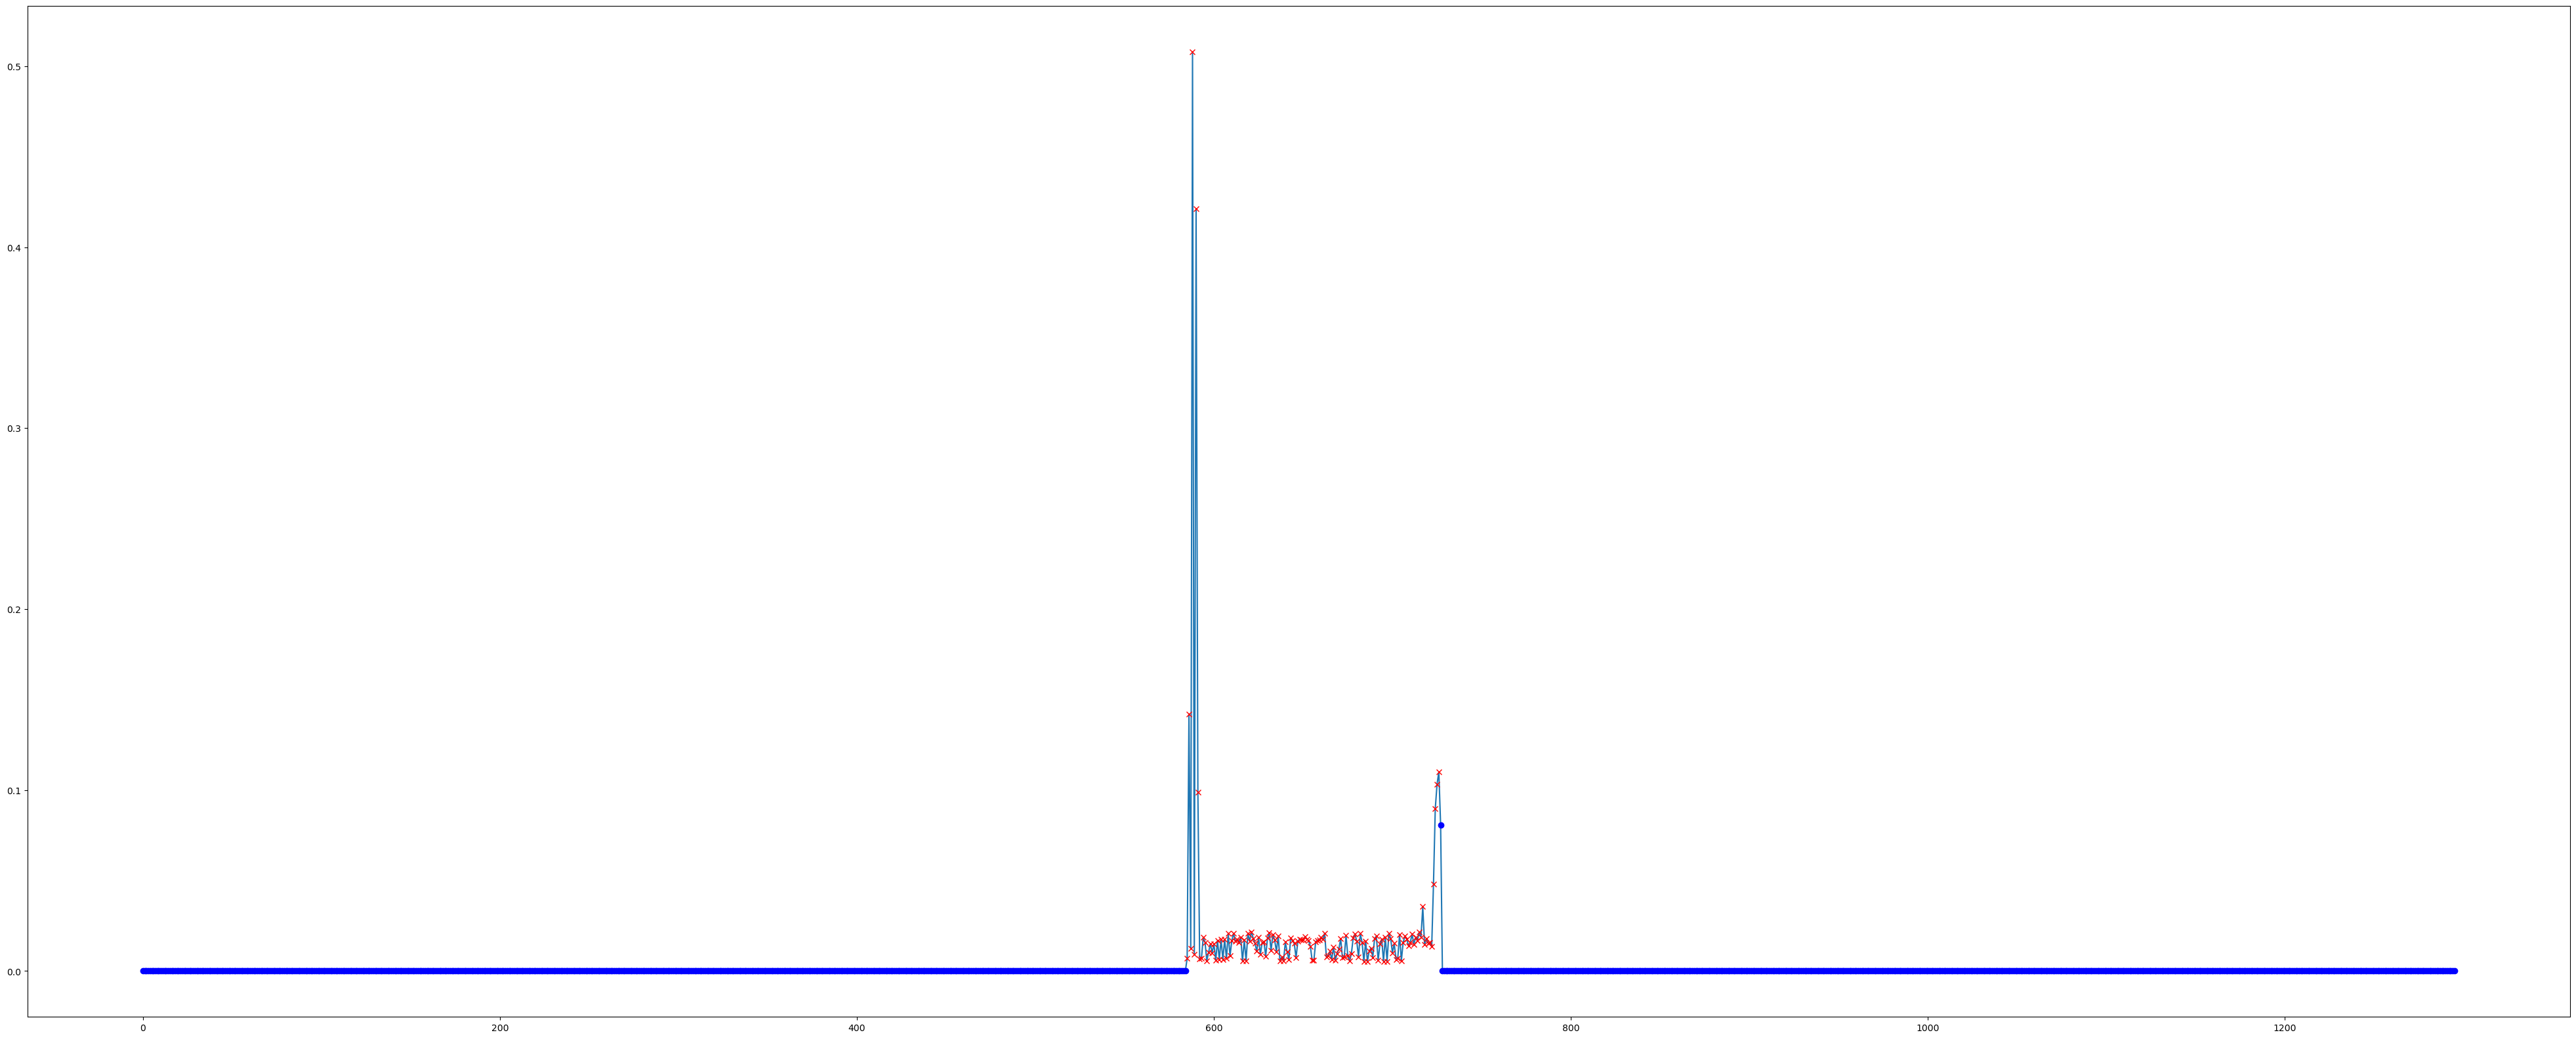

Counter({0: 1154, 1: 142})
1
4.6e-05
[103]
[143]


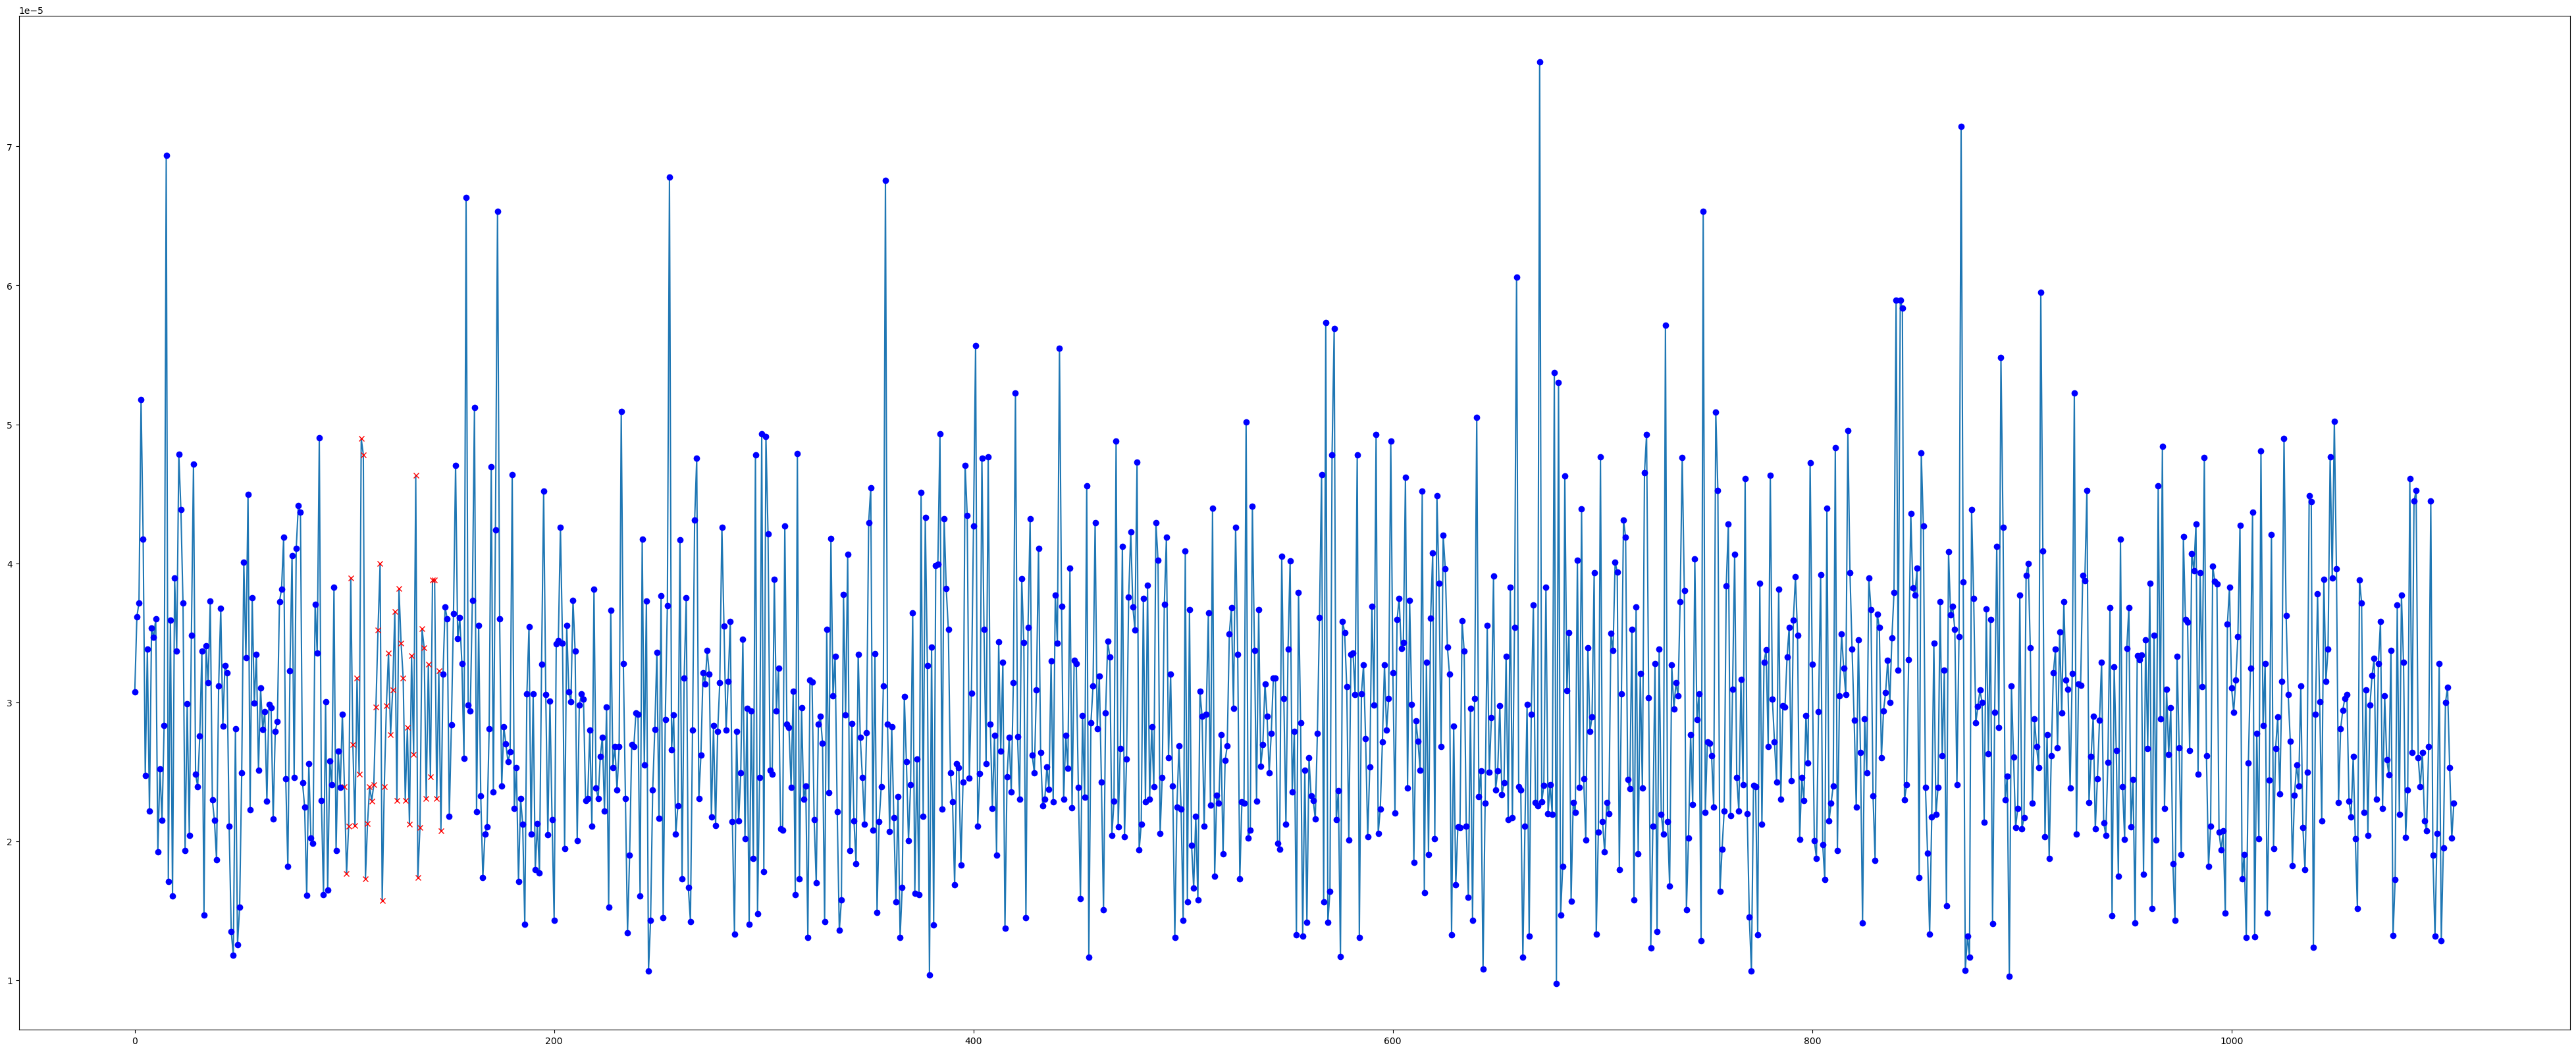

Counter({0: 1060, 1: 47})
2
0.005


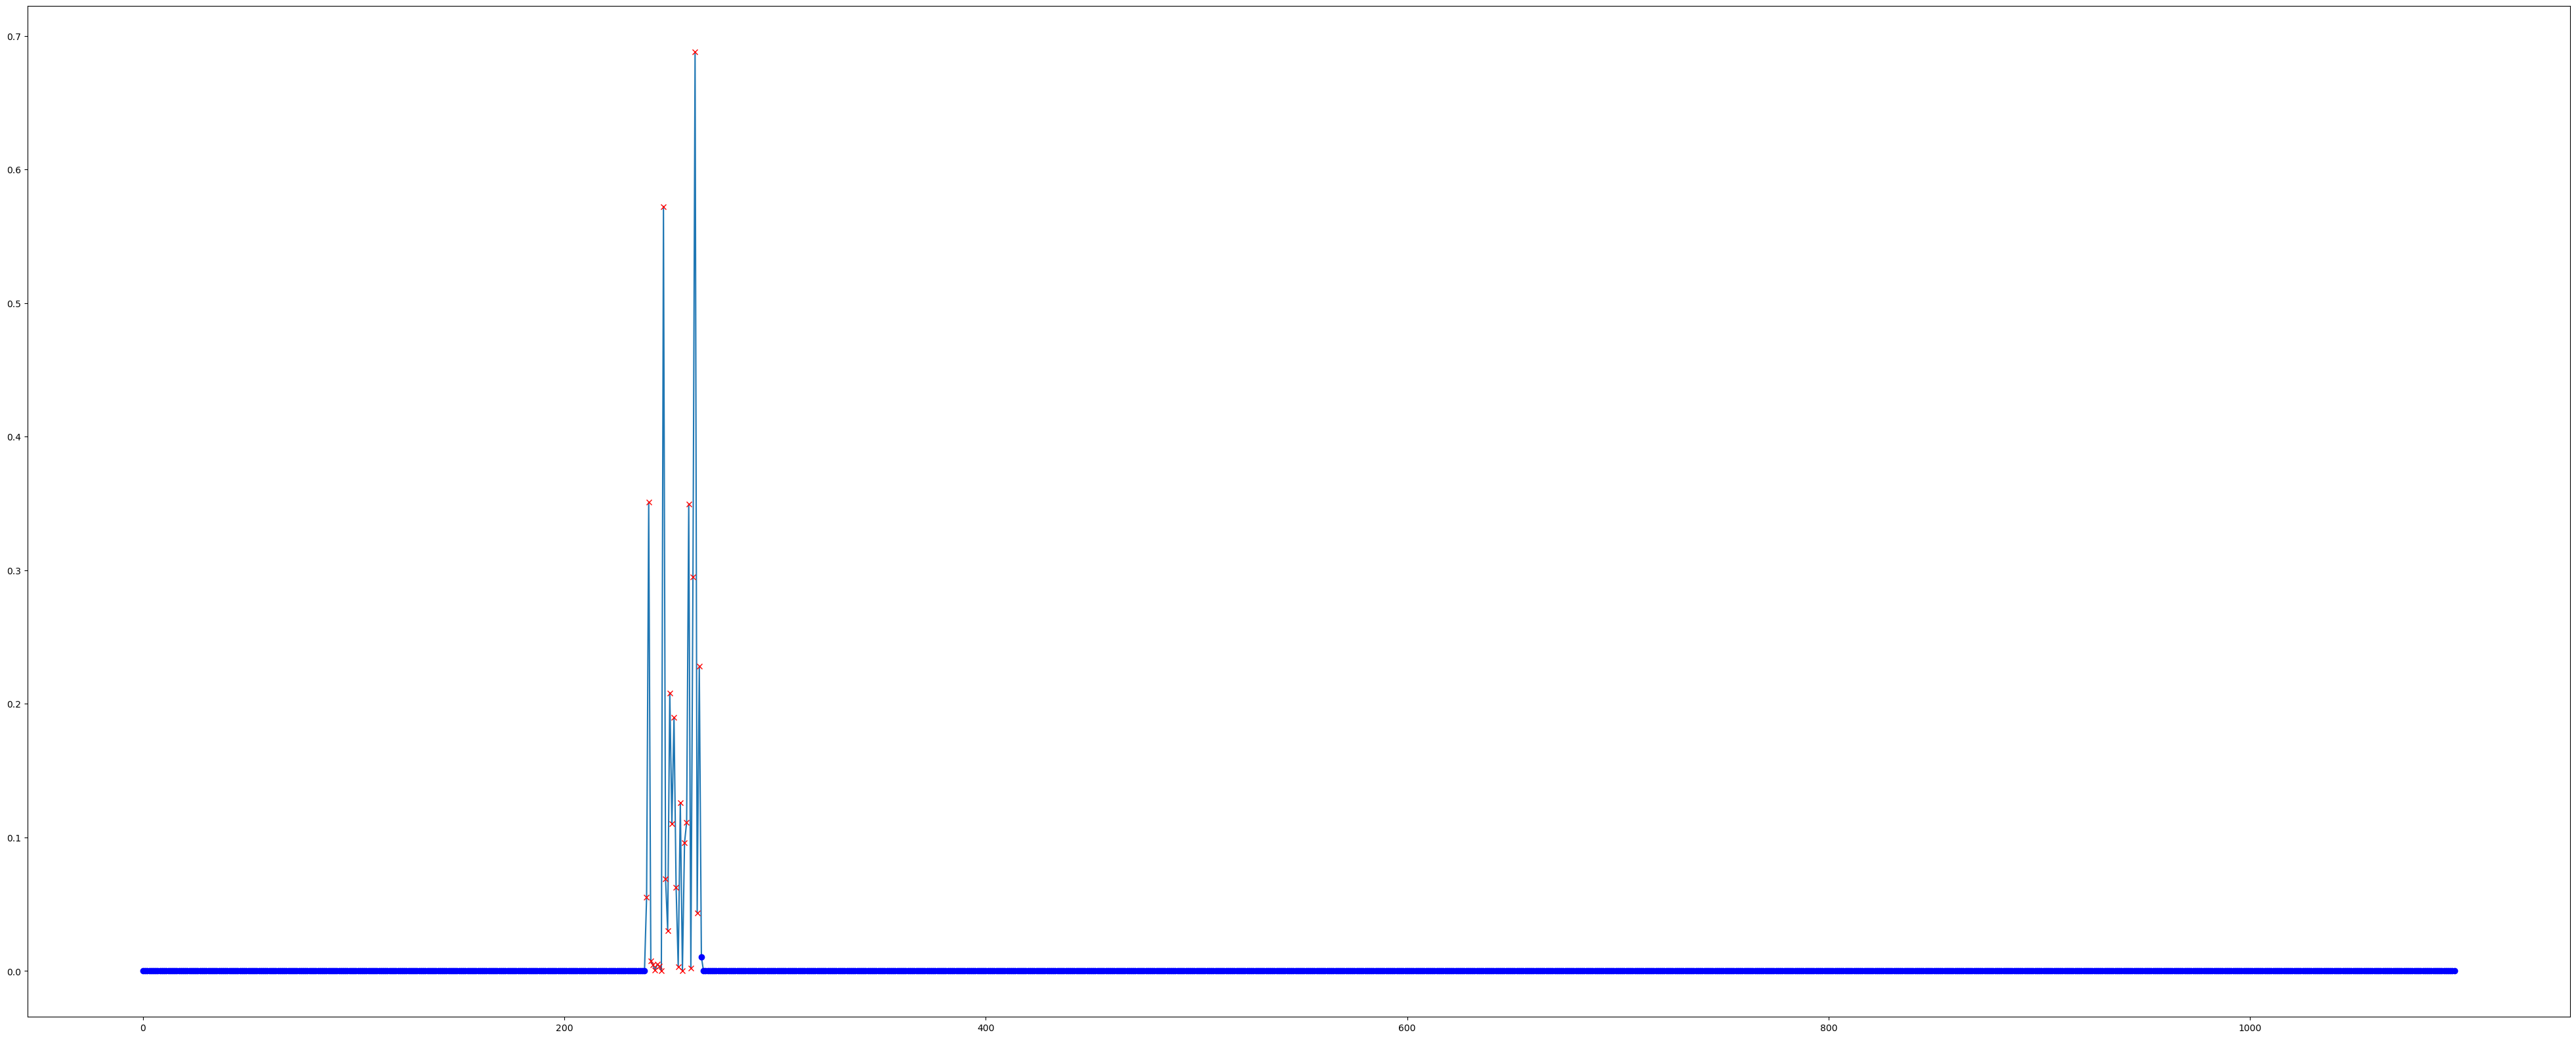

Counter({0: 1072, 1: 26})
3
0.01


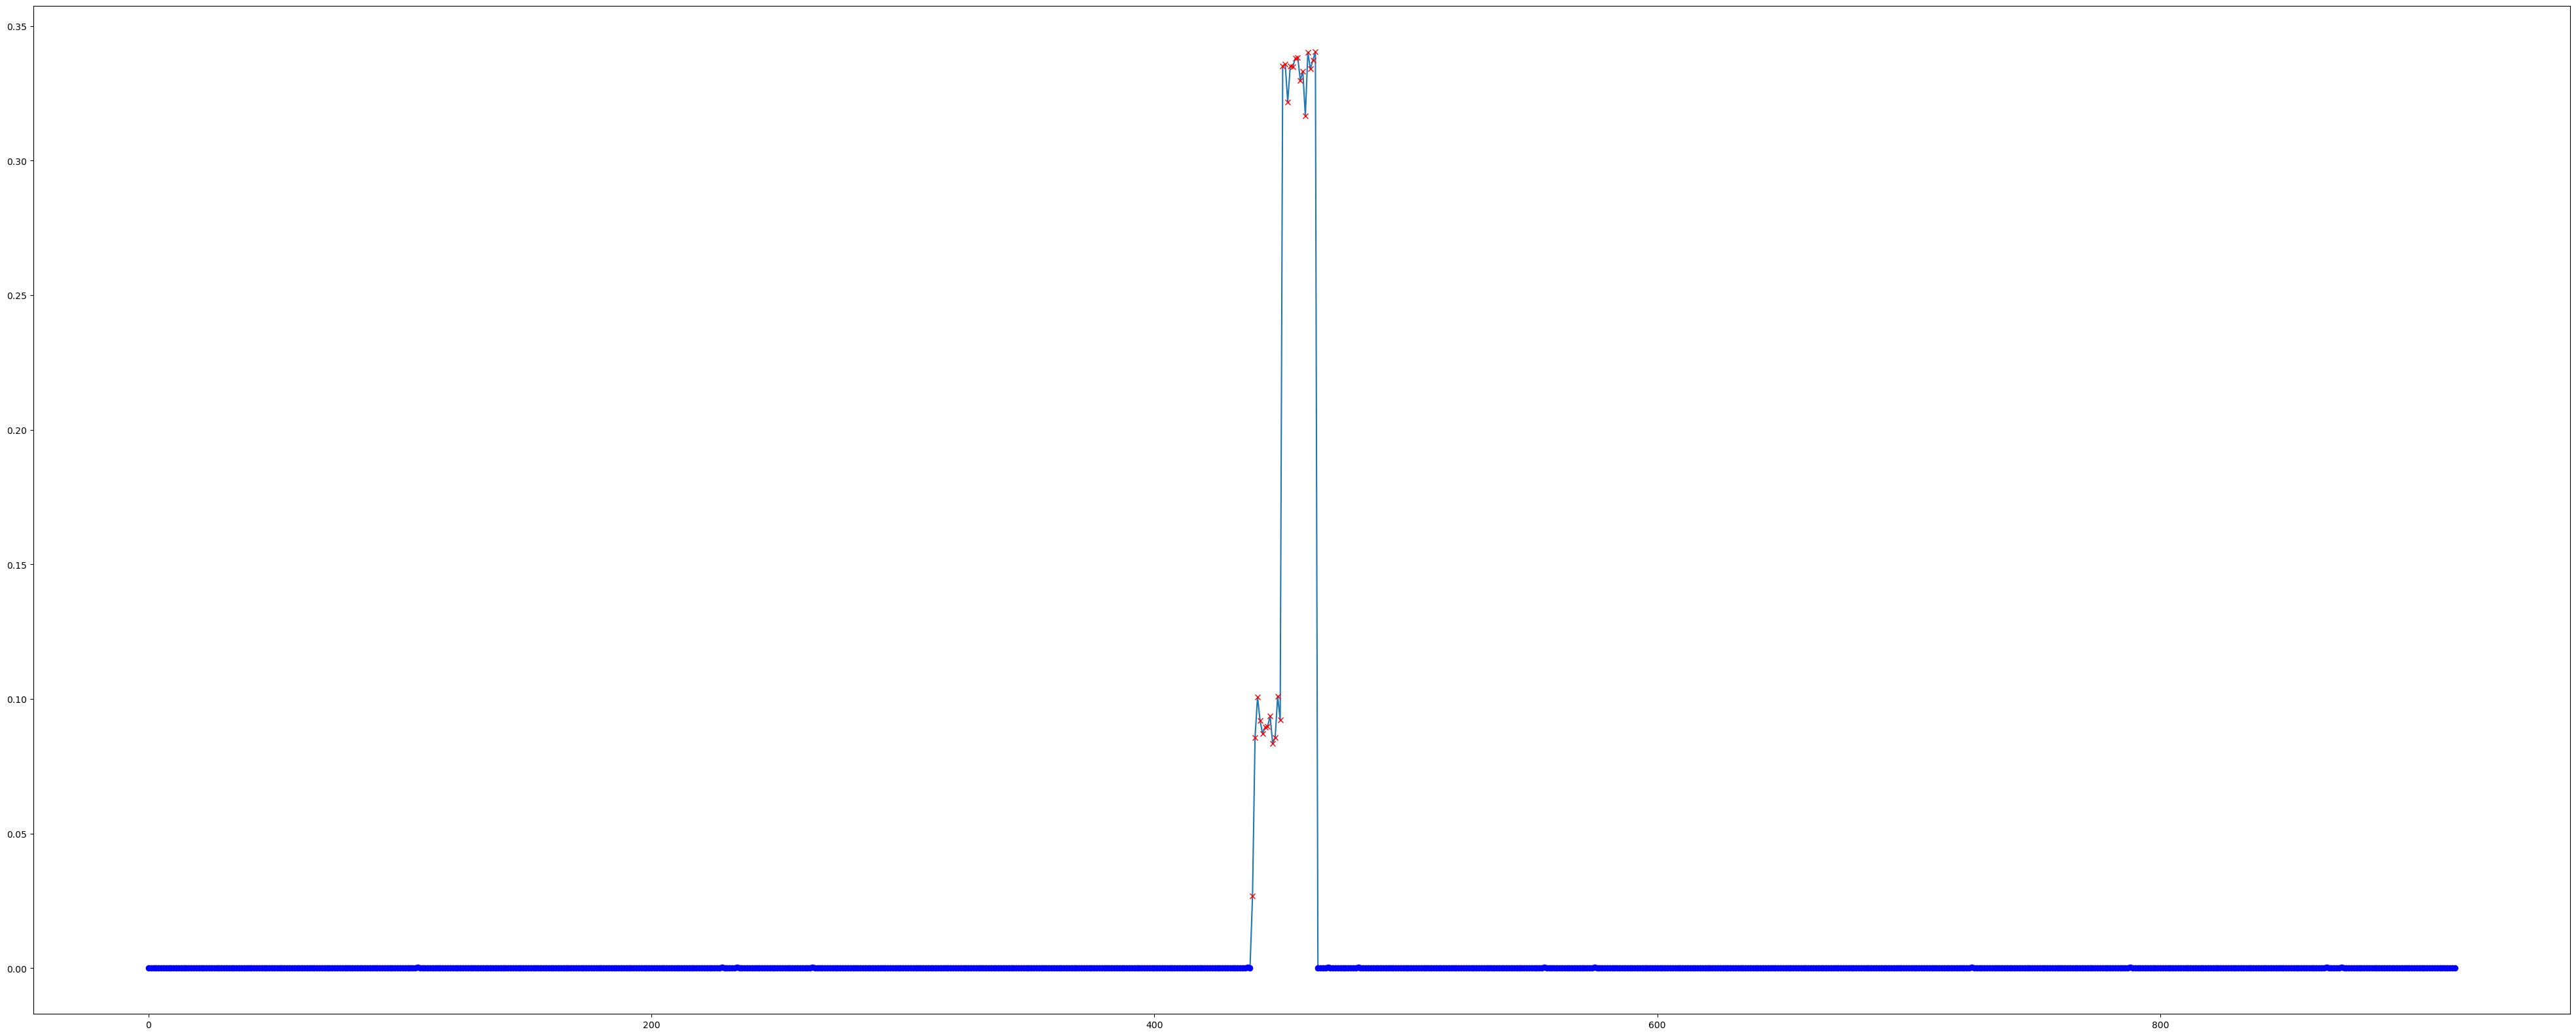

Counter({0: 892, 1: 26})
4
2e-05


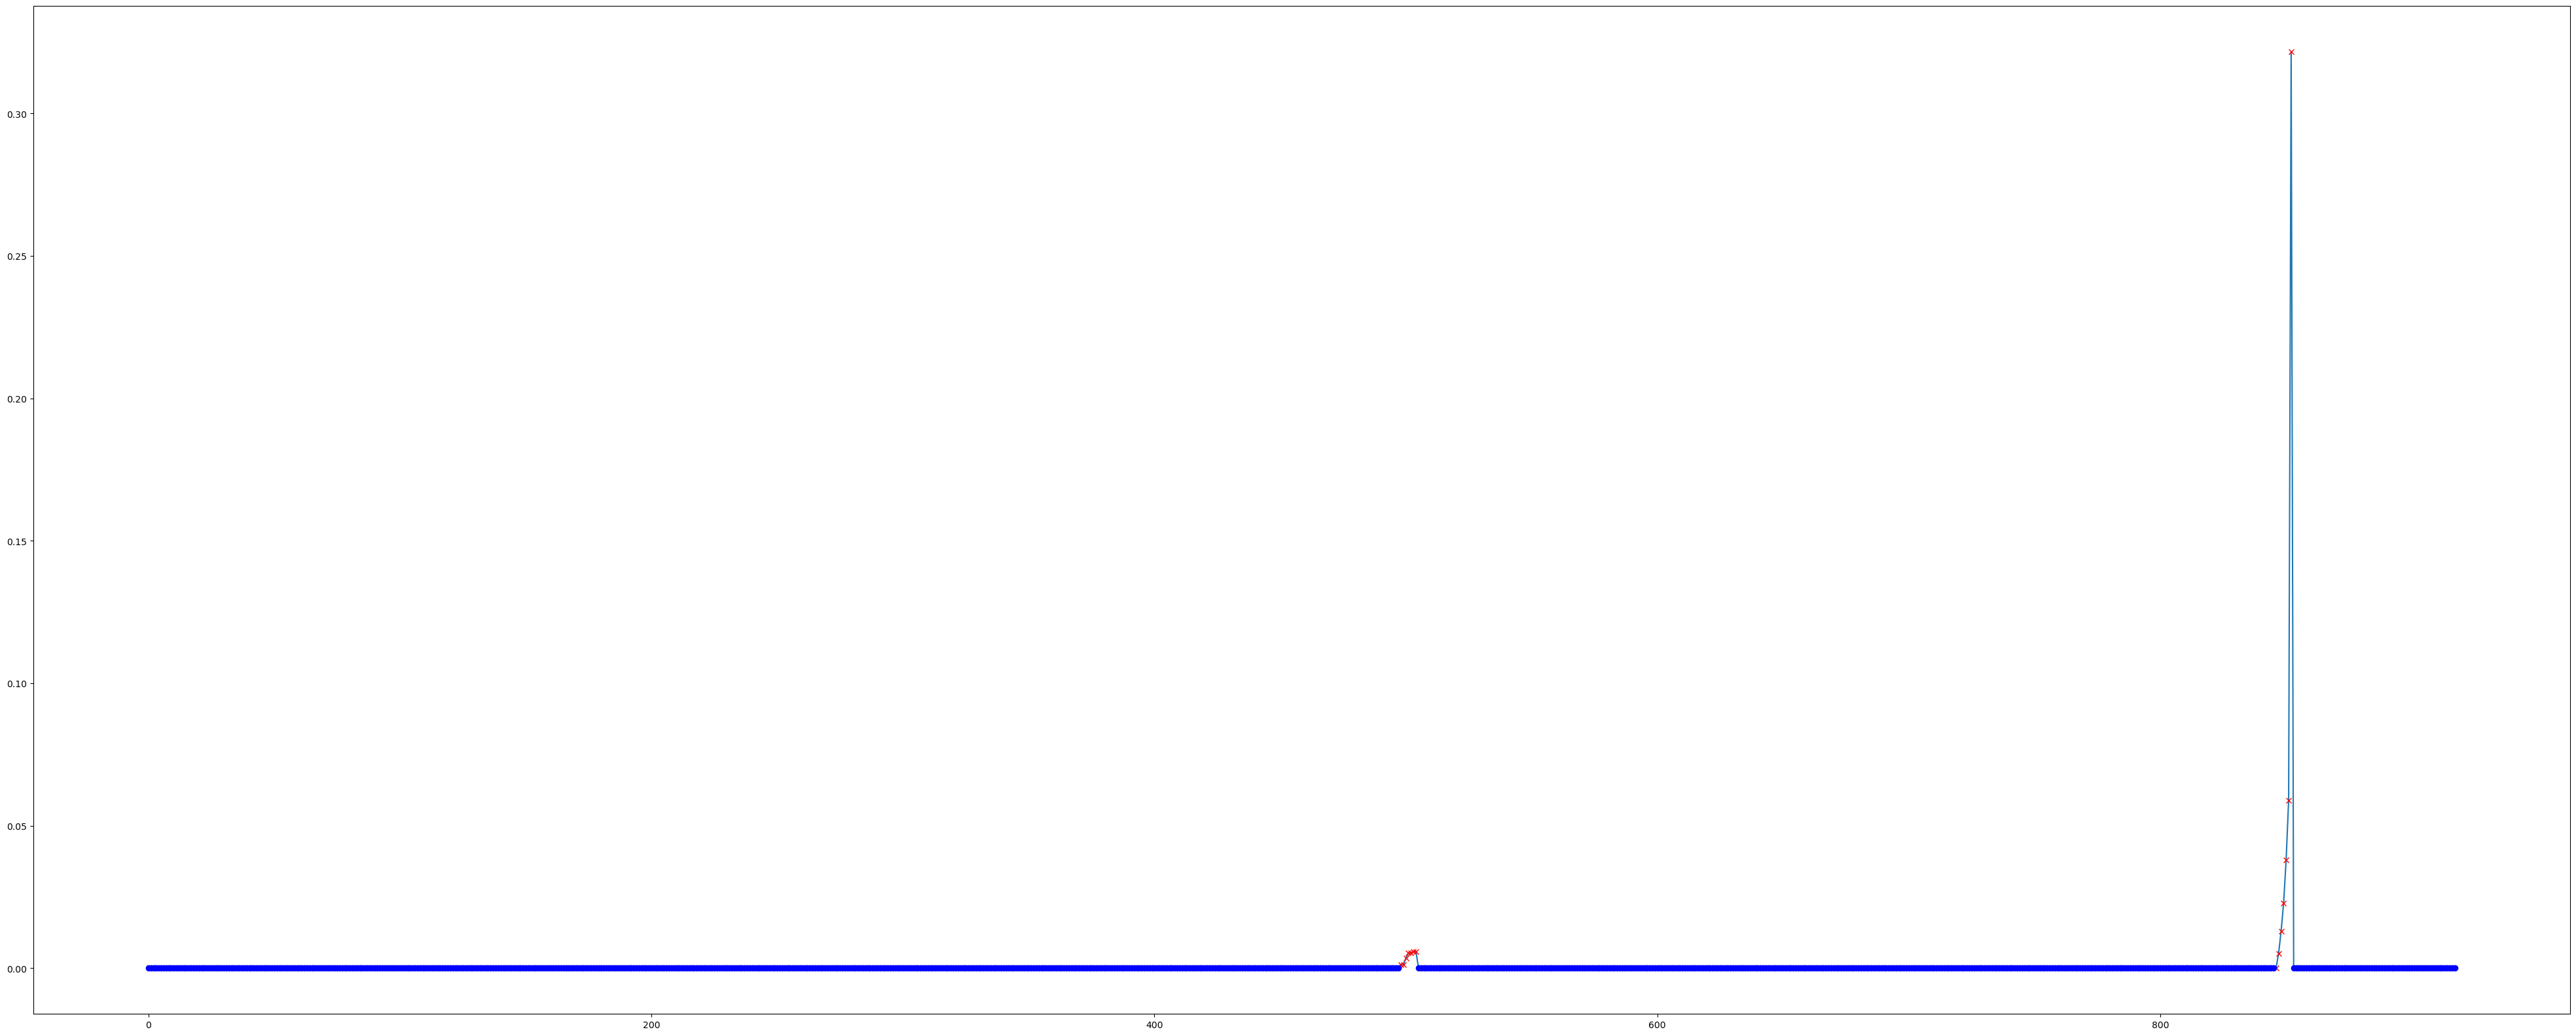

Counter({0: 904, 1: 14})
5
0.0001


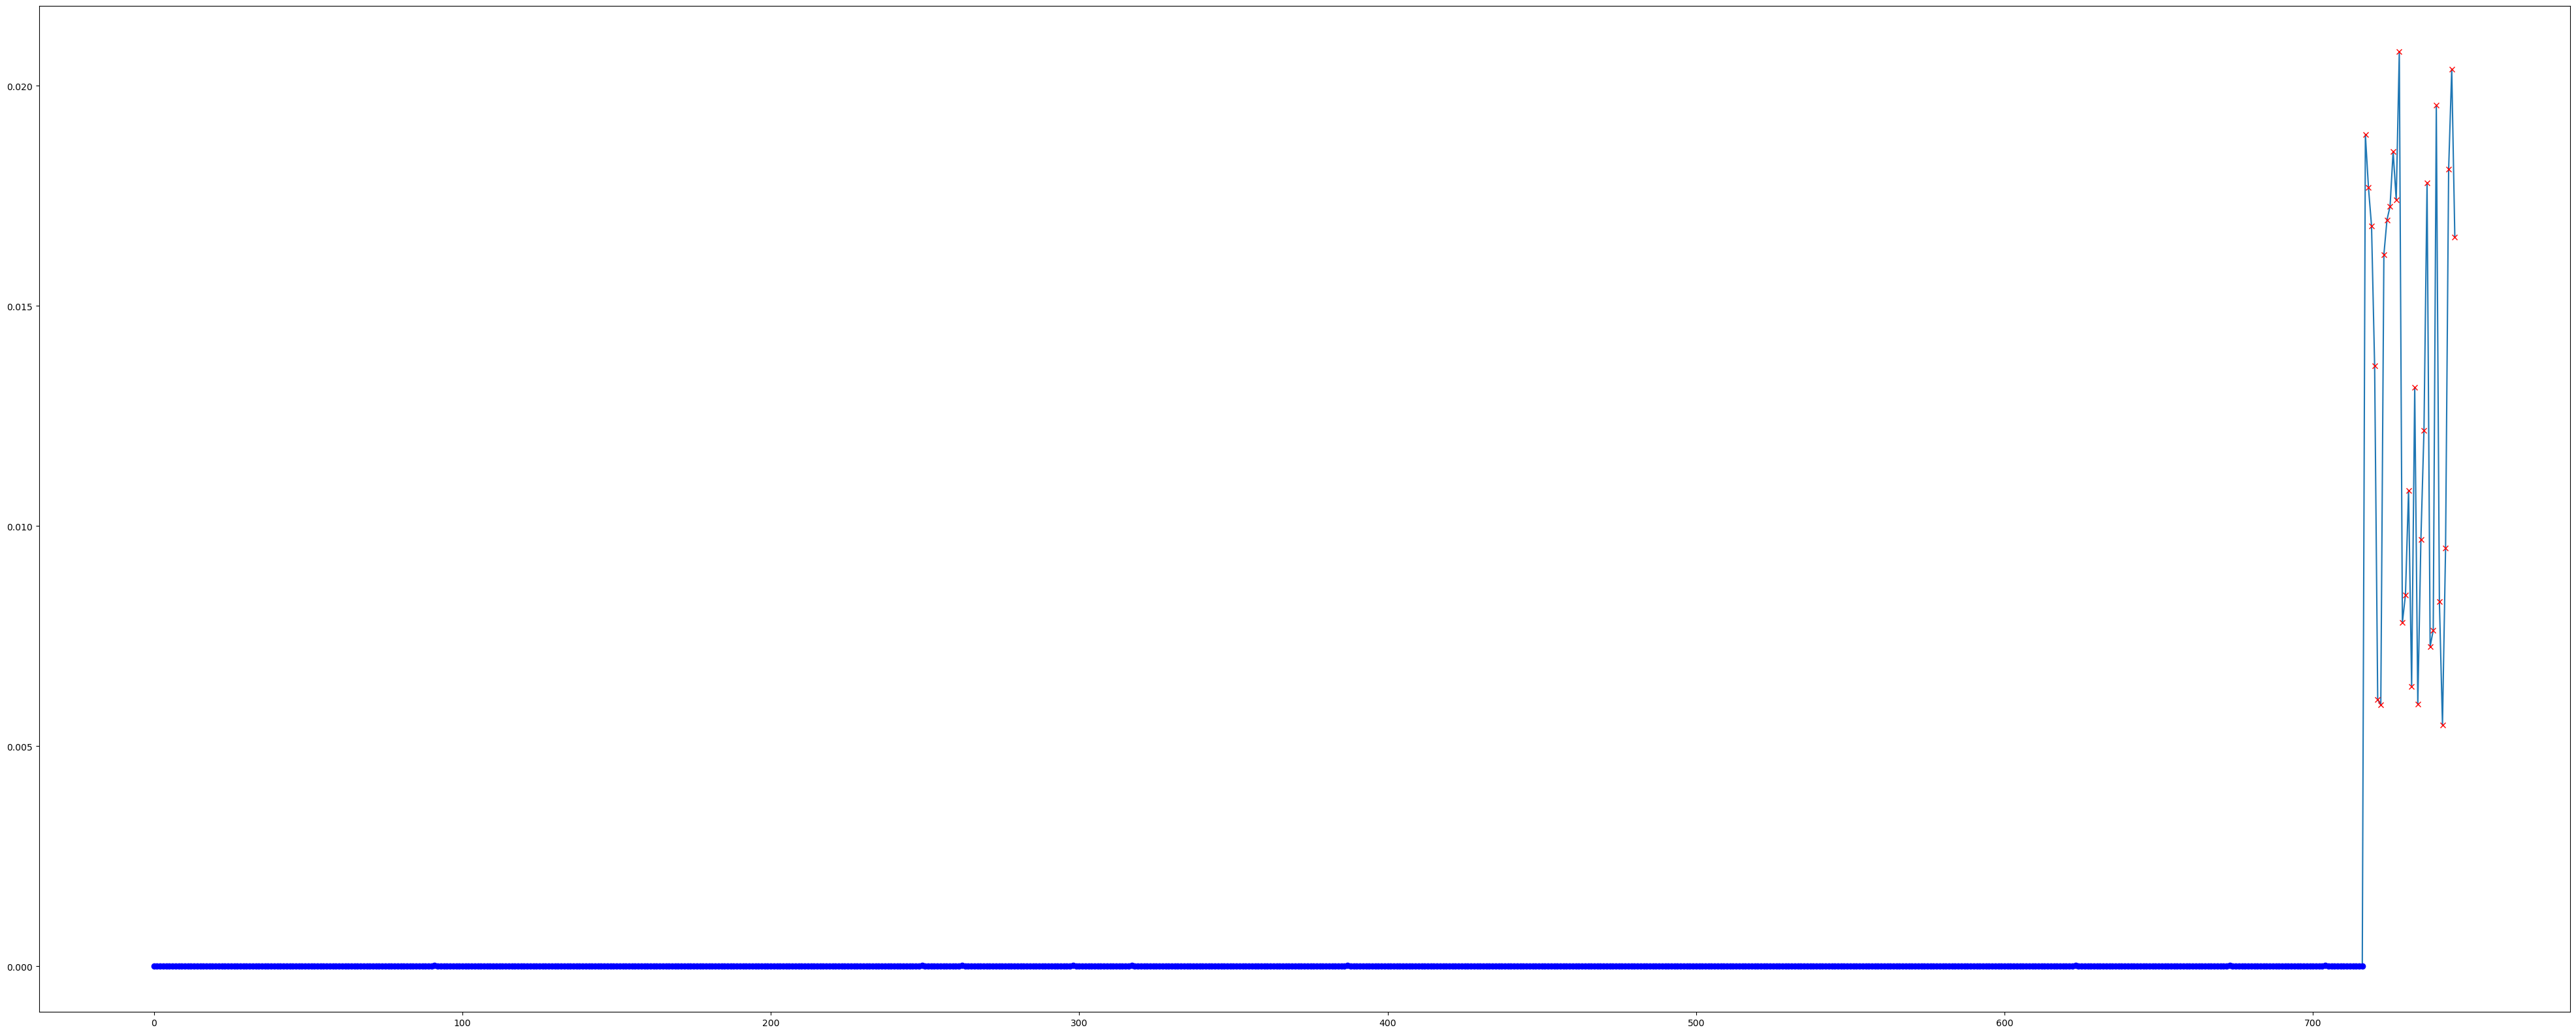

Counter({0: 717, 1: 30})
6
0.0001


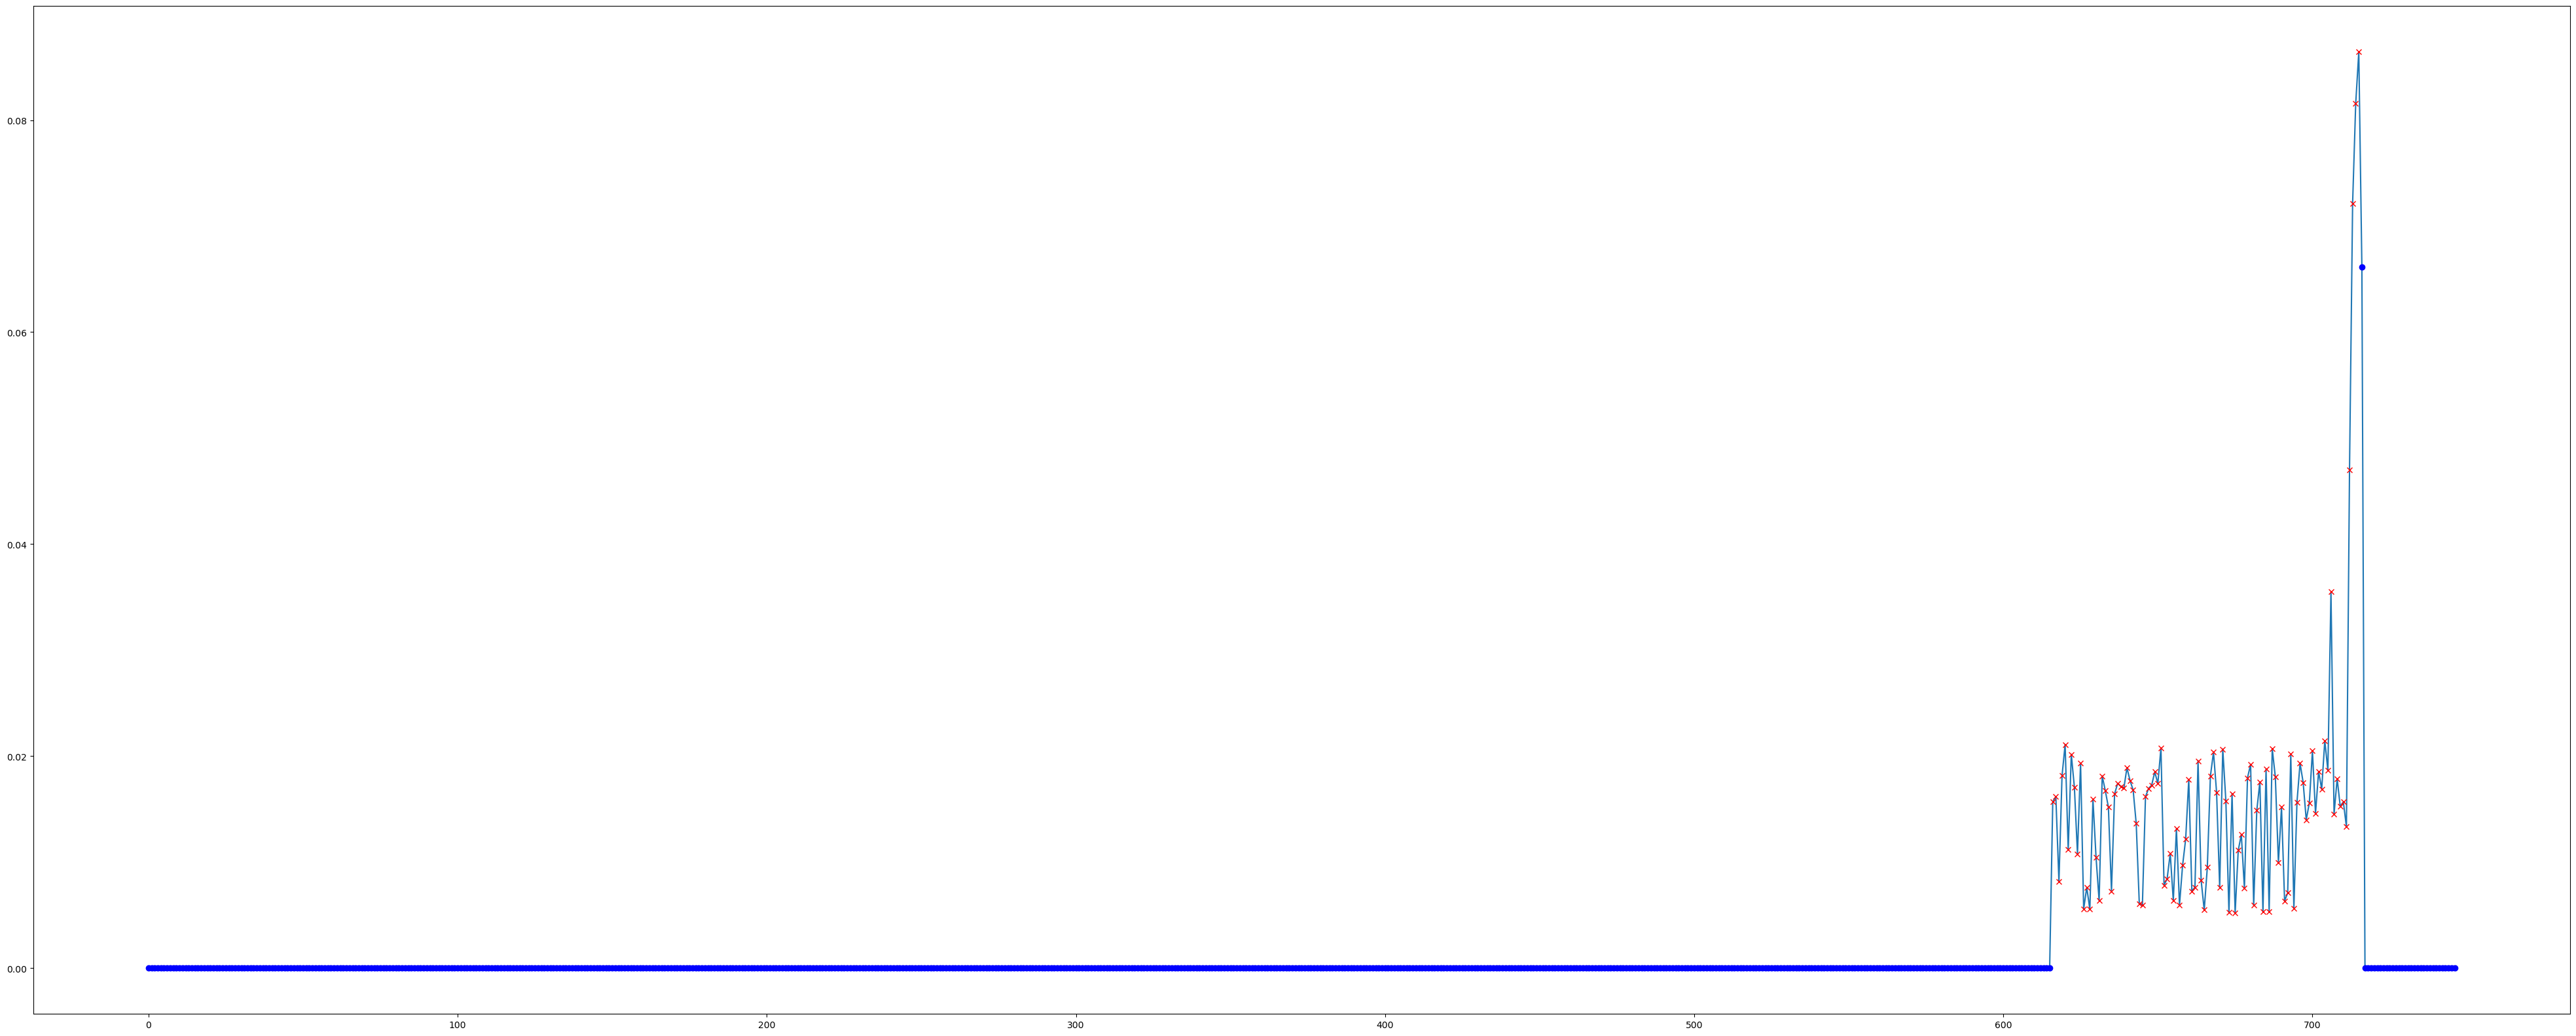

Counter({0: 647, 1: 100})
7
0.0001


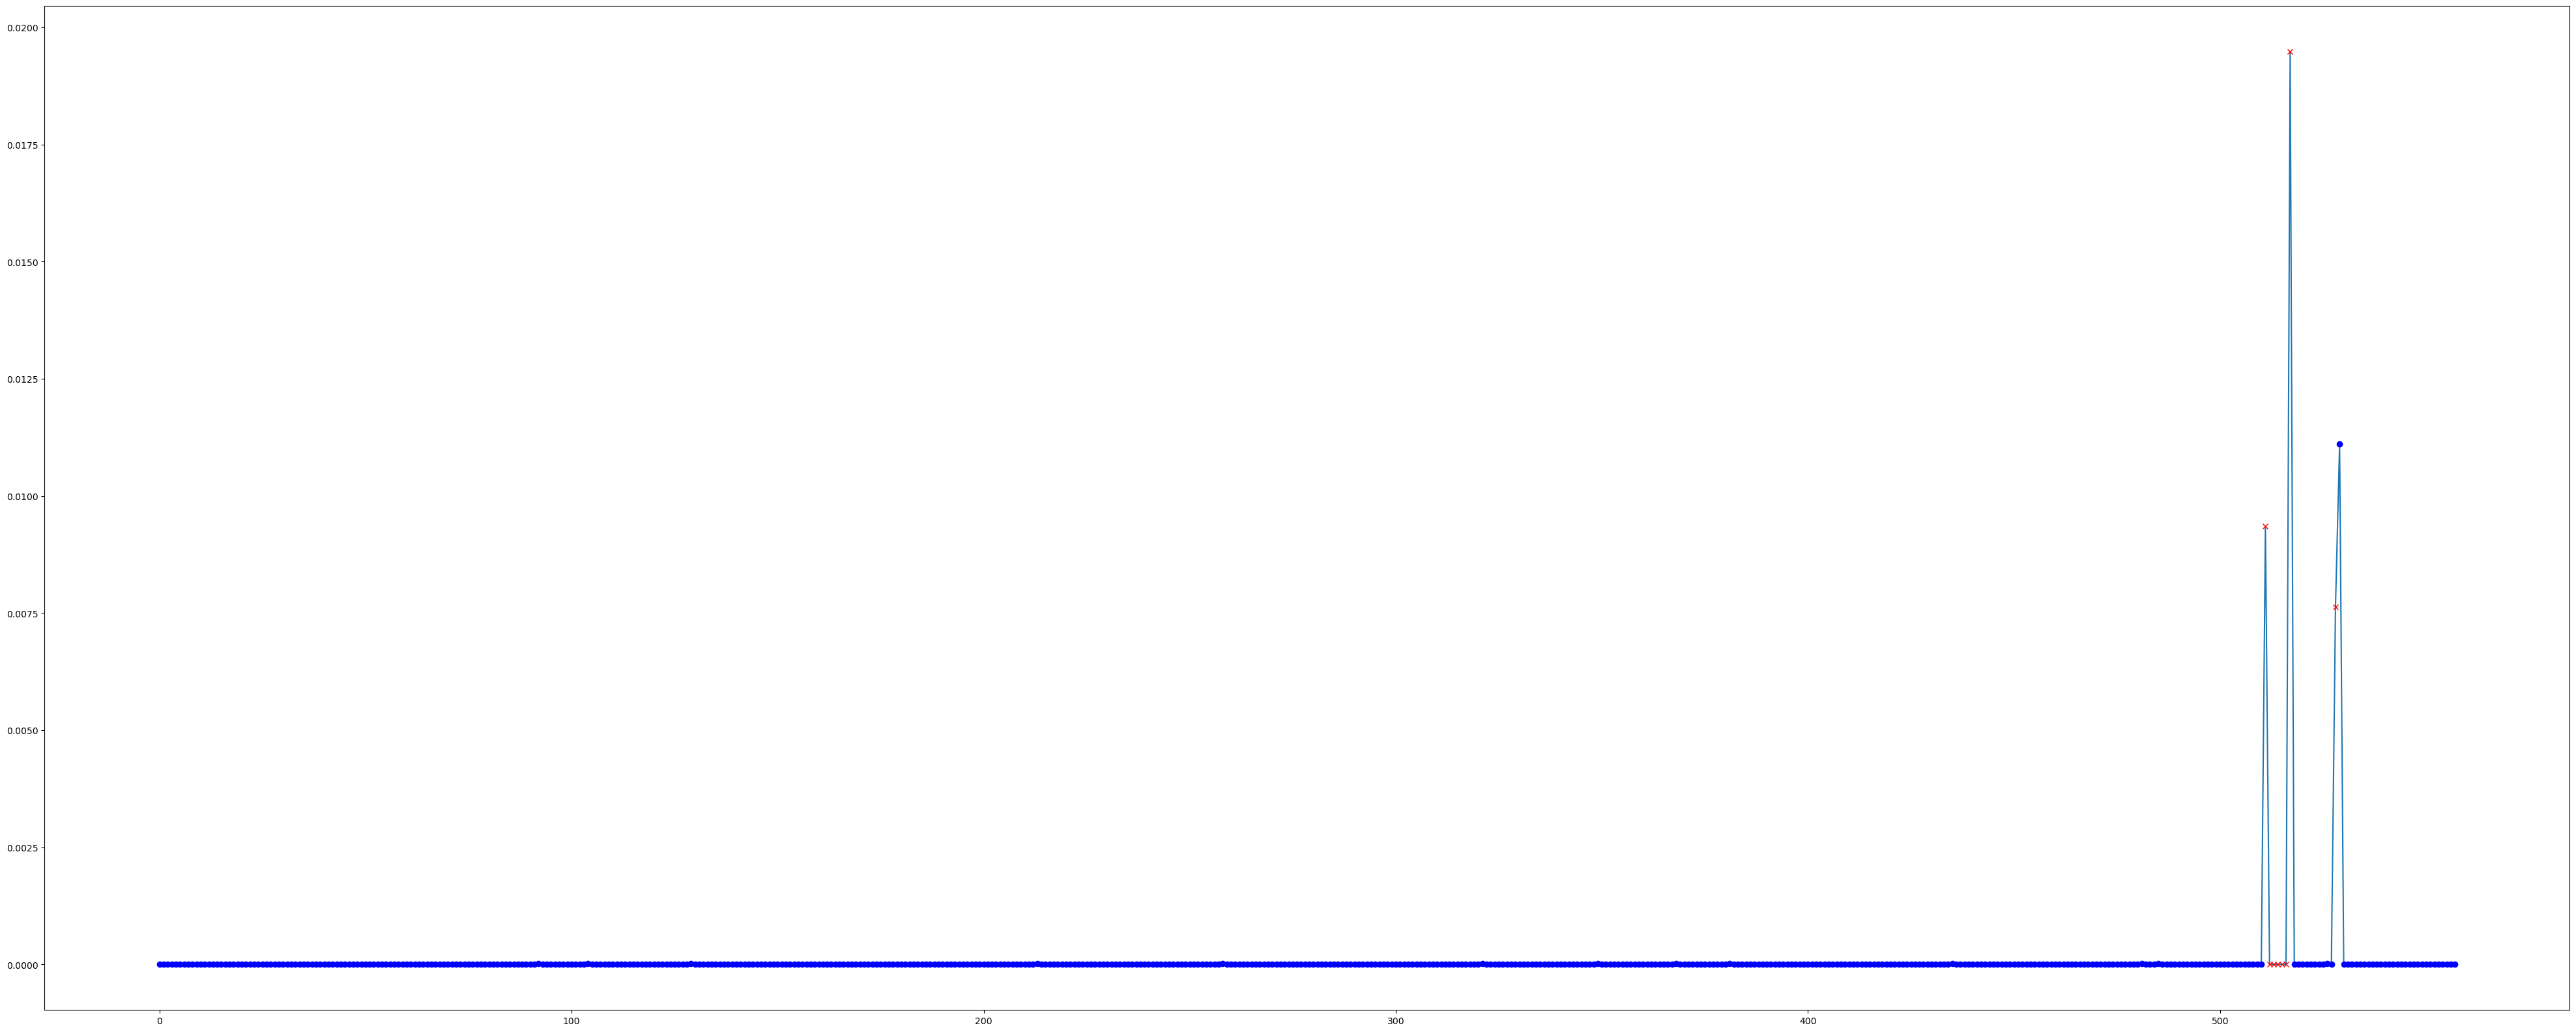

Counter({0: 550, 1: 8})
Counter({0: 6996, 1: 393})


In [16]:
threshold = [0.0001,0.000046,0.005,0.01,0.00002,0.0001,0.0001,0.0001]
threshold_type_2 = [0.2,0.02,0.02,0.02,0.02,0.02,0.07,0.015]

pred_all = [] 
#Predict Each Type
for i in range(len(test_each_list)):
    #Load Pretrained Model
    pretrained_model = torch.load('./' + MODEL_NAME+'.pth')
    pretrained_model = pretrained_model.to(device)
    pretrained_model.eval()
    summary(pretrained_model)
    
    test_data_drop =  test_each_list[i].drop('type', axis=1)
    test_data_drop.reset_index(drop=True, inplace=True)
    #Data Scaling
    scaler = load(open('./scaler.pkl', 'rb'))
    test_x = scaler.transform(test_data_drop)
    #Make Custom Dataset
    test_dataset = MyDataset(test_x)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    print(i)
    print(threshold[i])
    test_loss = []
    mse_list = []

    with torch.no_grad():
        for x in iter(test_loader):
            x = x.float().to(device)
            _x,encoded = pretrained_model(x)
            error = x-_x
            mse_each = np.power(error.numpy(),2).tolist()
            mse = np.mean(np.power(error.numpy(),2),axis=1)
            mse_list.extend(mse)
            
    if i!=1:
        mse_arr = torch.tensor(mse_list)
        #1차적으로 예측
        pred = torch.where(mse_arr > threshold[i] , 1, 0).detach().tolist()        
        flag = 0

        for idx in range(len(pred)-10): #구간 예측 ex. [10001000..000] 이런식으로 예측했다면 10 index 범위 내에서 [111110..0]으로 Prediction
            for k in range(2,10):
                if pred[idx]==1 and pred[idx+k]==1:
                    for j in range(1,k):
                        pred[idx+j] =1
    
        if i==0 or i==2 or i==6 or i==7: #구간의 마지막이 second threshold값보다 작다면 이상치처리 -> 특정 type에서는 Error가 크더라도 Nomral data
            for idx in range(len(mse_arr)-1):
                if pred[idx]== 1 and mse_arr[idx] < threshold_type_2[i] and pred[idx+1] == 0:
                        pred[idx] = 0

        
    #i==1은 오차의 시계열 특징으로 예측
    if i==1:
        #MSE의 오차의 특정 part에서 continuous peak value search
        mse_arr = torch.tensor(mse_list)
        first_filter = torch.where(mse_arr < 0.00005 , mse_arr, 0)
        second_filter = torch.where(first_filter > threshold[i],first_filter,0).detach().tolist()
        pred = [0 for i in range(len(mse_arr))]
        
        #find double peak
        double_peak_idx = []
        for idx in range(len(second_filter)-1):
            diff = second_filter[idx]-second_filter[idx+1]
            if diff  < 5e-6 and diff > 0 and second_filter[idx-1] ==0. and second_filter[idx+2] == 0:
                double_peak_idx.append(idx)
        anomaly_start_point = []
        anomaly_end_point = []
        #check before big peak
        for double_idx in double_peak_idx:
            flag=0
            for idx in range(double_idx-1, -1,-1):
                flag=1
                if mse_arr[idx] - mse_arr[idx+1] > 1e-5 and mse_arr[idx] - mse_arr[idx-1] > 1e-5 :
                    anomaly_start_point.append(idx)
                    break;
            if flag==0:
                anomaly_end_point.append(len(mse_arr)-1) # Error Exception

        #check after double peak
        for double_idx in double_peak_idx:
            flag = 0
            for idx in range(double_idx,len(mse_arr)-2):
                if mse_arr[idx+1] - mse_arr[idx] < 5e-6 and mse_arr[idx+1] - mse_arr[idx] > 0 and mse_arr[idx+1]- mse_arr[idx+2] > 1e-5 and mse_arr[idx] - mse_arr[idx-1] > 1e-5:
                    flag=1
                    anomaly_end_point.append(idx+1)
                    break;
            if flag==0:
                anomaly_end_point.append(len(mse_arr)-1) #Error Exception
        
        #Predict Anomaly Interval (end point보다 3개 더 예측 -> 대략적인 구간 예측)
        print(anomaly_start_point)
        print(anomaly_end_point)
        for interval_cnt in range(len(anomaly_end_point)):
            for idx in range(max(0,anomaly_start_point[interval_cnt]-3), min(anomaly_end_point[interval_cnt]+4,len(pred))):
                pred[idx] = 1
            

    plt.figure(figsize=(50,20))
    plt.plot(mse_list)
        
    for idx in range(len(pred)):
        if pred[idx] ==1:
            plt.plot(idx, mse_list[idx],'rx')
    for idx in range(len(pred)):
        if pred[idx] ==0:
            plt.plot(idx, mse_list[idx],'bo')
    


    plt.show()
    print(Counter(pred)) 
    
    pred_all.extend(pred)
print(Counter(pred_all))

In [15]:
zero = 0
one = 0
for  i in range(len(pred_all)):
    if pred_all[i] == 0:
        zero = zero+1
    else:
        one = one+1    
print(f'{zero}, {one}')

6996, 393


In [729]:
submit = pd.read_csv('./dataset/answer_sample.csv')
submit['label'] = pred_all
submit.to_csv(f'./AE_20.csv')